#### 1. Spatial aggregation
Note: The gridded data cells do not all correspond to the same areas. And the area of grid cell varies as a function of  the cosine of the latitude.
#### 2. Temporal aggregation
monthly to yearly.


In [1]:
# General libs for file paths, data extraction, etc
from glob import glob
import numpy as np
import xarray as xr
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import geopandas as gpd
import rasterio as rio
from rasterio.features import geometry_mask
import cartopy.crs as ccrs
import cartopy.feature as cfeat


In [2]:
def geog_agg(da, exp, mod):
    ## spatial aggregation
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_sa = da_weighted.mean(['lat', 'lon'])
    ## temporal aggregation
    da_sa_ta = da_sa.groupby('time.year').mean()
    da_sa_ta = da_sa_ta - 273.15
    ## assign coordinates
    da_sa_ta = da_sa_ta.assign_coords(model=mod)
    da_sa_ta = da_sa_ta.expand_dims('model')
    da_sa_ta = da_sa_ta.assign_coords(experiment=exp)
    da_sa_ta = da_sa_ta.expand_dims('experiment')
    return da_sa_ta


In [3]:
# DATADIR = 'tmp/'
DATADIR = 'data/climate/cmip6'
path_hma_gtng = 'data/extents/HMA/gtng_202307_hma_subregions.gpkg'
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']
          

In [4]:
path_cmip6_nc = glob(f'{DATADIR}/*/tas*.nc')
path_cmip6_nc[0:2]


['data/climate/cmip6/ssp585/tas_Amon_NESM3_ssp585_r1i1p1f1_gn_201501-210012.nc',
 'data/climate/cmip6/ssp585/tas_Amon_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_201501-210012.nc']

In [5]:
ds = xr.open_dataset(path_cmip6_nc[0])
hma_gtng = gpd.read_file(path_hma_gtng)
hma_mask = hma_gtng.geometry.unary_union
hma_gdf = gpd.GeoDataFrame(geometry=[hma_mask])


<GeoAxes: title={'center': 'time = 2015-01-16T12:00:00, height = 2.0 [m]'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

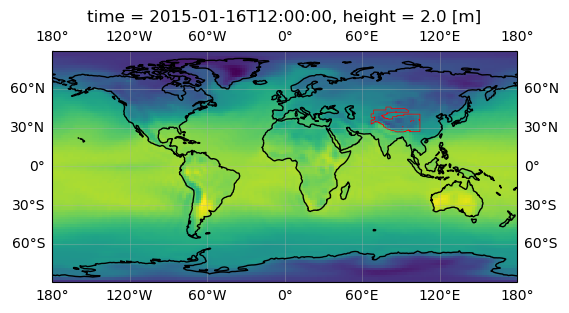

In [6]:
### show the global data
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1, projection=proj)  ## 通过.add_subplot()该方式添加投影
ax.add_feature(cfeat.COASTLINE)  ## 添加海岸线
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
ds['tas'][0].plot(ax=ax, transform=ccrs.PlateCarree(),add_colorbar=False)
hma_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)


In [7]:
def ds_mask_hma(ds):
  # Mask out the region outside of hma_gtng
  transform = rio.transform.from_bounds(ds.lon.min().item(), ds.lat.max().item(), \
                                              ds.lon.max().item(), ds.lat.min().item(), \
                                              ds.dims['lon'], ds.dims['lat'])
  mask = geometry_mask([hma_mask], transform=transform, invert=True, out_shape=(ds.dims['lat'], ds.dims['lon']))
  mask_da = xr.DataArray(mask, dims=["lat", "lon"], coords={"lat": ds.lat, "lon": ds.lon})
  da_hma = ds.where(mask_da, drop=True)
  return da_hma
ds_hma = ds_mask_hma(ds)
ds_hma


<xarray.Dataset> Size: 4MB
Dimensions:    (time: 1032, bnds: 2, lat: 10, lon: 20)
Coordinates:
  * time       (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16T1...
  * lat        (lat) float64 80B 28.91 30.78 32.64 34.51 ... 41.97 43.83 45.7
  * lon        (lon) float64 160B 67.5 69.38 71.25 73.12 ... 99.38 101.2 103.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat, lon) datetime64[ns] 3MB NaT NaT NaT ... NaT NaT
    lat_bnds   (lat, bnds, lon) float64 3kB nan nan nan nan ... nan nan nan nan
    lon_bnds   (lon, bnds, lat) float64 3kB nan nan nan 67.5 ... nan nan nan
    tas        (time, lat, lon) float32 826kB nan nan nan nan ... nan nan nan
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2015.0
    contact:                esmc@nuist.edu.cn
    ...                     ...
    title:                  NESM3 output prepared for CMIP6
    tracking_id:            hdl:21.14100/fe26214f-a5ff-411a-b25d-f867dcf8f894
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by Lawrence Livermore P...
    cmor_version:           3.4.0

<GeoAxes: title={'center': 'time = 2015-01-16T12:00:00, height = 2.0 [m]'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

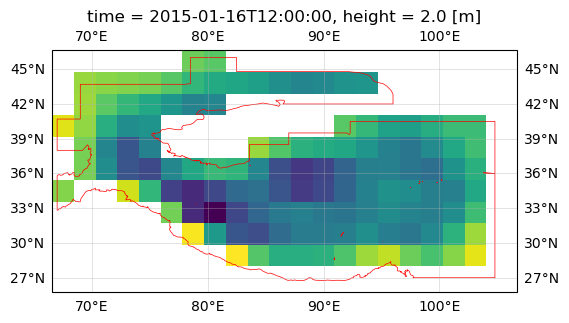

In [8]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1, projection=proj)  ## 
ax.add_feature(cfeat.COASTLINE)  ## 
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
ds_hma['tas'][0].plot(ax=ax, transform=ccrs.PlateCarree(),add_colorbar=False)
hma_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)


In [10]:
for path in path_cmip6_nc:
    ds = xr.open_dataset(path)
    if 'latitude' in ds.coords:
        ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    if 'height' in ds.coords:
        ds = ds.drop_vars('height')
    ds_hma = ds_mask_hma(ds)
    da_hma = ds_hma['tas']
    exp, mod = ds.attrs['experiment_id'], ds.attrs['source_id']
    try:
        da_sa_ta = geog_agg(da=da_hma, exp=exp, mod=mod)
        da_sa_ta.to_netcdf(path=f'{DATADIR}/{exp}/cmip6_agg_{exp}_{mod}_{str(da_sa_ta.year[0].values)}_{str(da_sa_ta.year[-1].values)}.nc')
    except: print(f'{path} failed')


In [13]:
data_ds_hma = xr.open_mfdataset(f'{DATADIR}/*/cmip6_agg*.nc')
data_ds_hma.load()   ## convert Dask arrays into in-memory arrays
data_ds_hma
data_da_hma = data_ds_hma['tas']
# data_da


#### Visualization

In [21]:
data_90 = data_da_hma.quantile(0.9, dim='model')
data_10 = data_da_hma.quantile(0.1, dim='model')
data_50 = data_da_hma.quantile(0.5, dim='model')


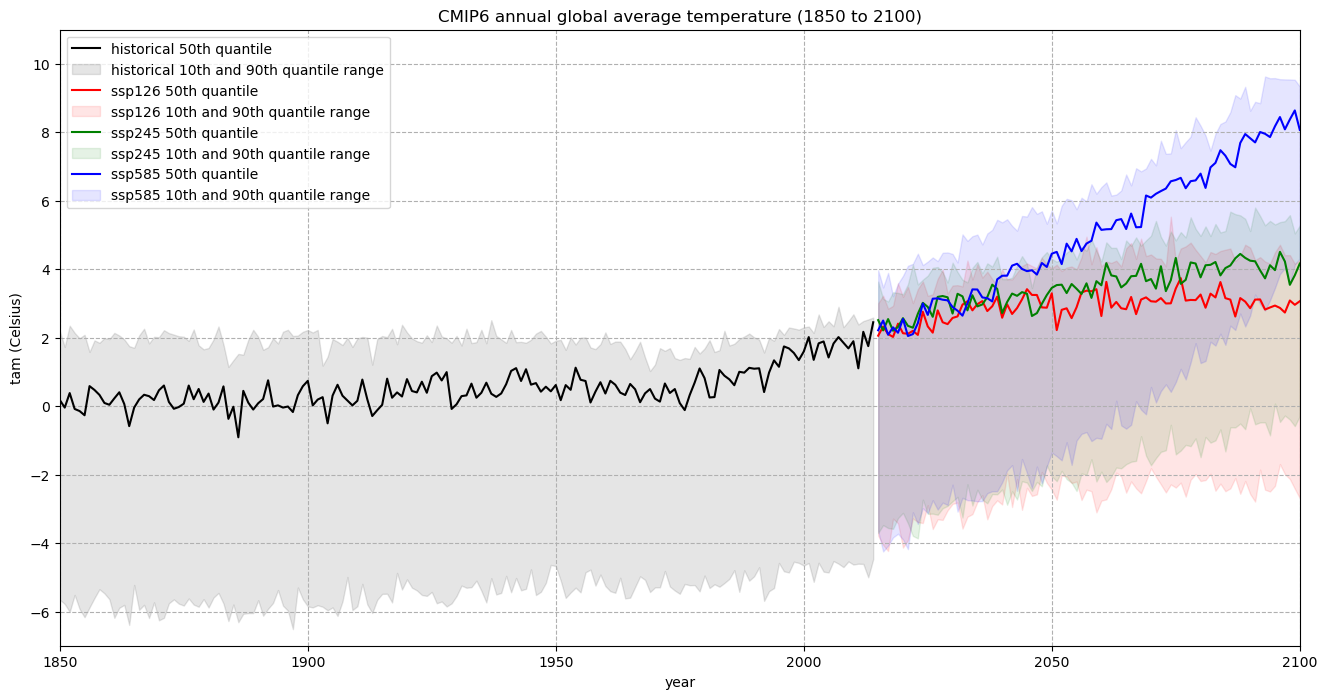

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')
ax.set_xlim(1850, 2100)
ax.set_ylim(-7, 11)
ax.set_title('CMIP6 annual global average temperature (1850 to 2100)')
ax.set_ylabel('tam (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')
# fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')


